### Load Library

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.preprocessing import StandardScaler
from skimage.feature import canny
import matplotlib.pyplot as plt

### Load Path Dataset

In [2]:
# Path dataset lokal
train_folder = 'dataset/final_dataset/train'
test_folder = 'dataset/final_dataset/test'

### Ekstrasi Fitur

In [39]:
def fetch_image(image_path, size=(200, 200)):
    # Membaca gambar
    image = cv2.imread(image_path)  # Menggunakan variabel `image_path`
    if image is None:
        raise ValueError(f"Gambar tidak ditemukan atau tidak dapat dibaca: {image_path}")
    
    # Resize ke ukuran awal
    face_crop = cv2.resize(image, size)

    # Mengurangi area gambar sebesar 30% (70% dari ukuran asli)
    height, width = face_crop.shape[:2]
    new_height = int(height * 0.70)
    new_width = int(width * 0.70)

    # Menghitung margin untuk cropping agar tetap di tengah
    top_margin = (height - new_height) // 2
    left_margin = (width - new_width) // 2

    # Memotong area gambar
    face_crop = face_crop[top_margin:top_margin + new_height, left_margin:left_margin + new_width]

    # Resize kembali hasil cropping ke ukuran `size`
    face_crop = cv2.resize(face_crop, size)

    return face_crop, image


In [46]:
def features_quadrants(img):
    """
    Calculate mean and std for 64 quadrants of the image.
    """
    h, w = img.shape  # Ambil tinggi dan lebar gambar
    h_step, w_step = h // 20, w // 20  # Ukuran setiap kuadran (dibagi 20x20)

    features = []
    for i in range(20):  # Iterasi untuk setiap baris kuadran
        for j in range(20):  # Iterasi untuk setiap kolom kuadran
            # Potong kuadran berdasarkan indeks
            quad = img[i * h_step:(i + 1) * h_step, j * w_step:(j + 1) * w_step]
            features.append(np.mean(quad))  # Hitung mean kuadran
            features.append(np.std(quad))   # Hitung std kuadran
            features.append(np.sum(quad))   # Hitung sum kuadran

    # print( "6 Features pertama: ",features[0:6])
    return np.array(features, dtype='float32')


In [18]:
# Defining a function to return the class labels corresponding to the age-ranges shown above.
def class_labels(age):
    if 0 <= age <= 12:
        return 0
    elif 13 <= age <= 20:
        return 1
    elif 21 <= age <= 30:
        return 2
    elif 31 <= age <= 40:
        return 3
    elif 41 <= age <= 50:
        return 4
    else:
        return 5

In [33]:
# Fungsi untuk mendapatkan target label berdasarkan struktur folder
def load_images_and_labels(folder_path):
    data = []
    for root, _, files in os.walk(folder_path):
        for file_name in files:
            if file_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                file_path = os.path.join(root, file_name)
                # Ekstrak label dari angka sebelum ekstensi
                age = int(file_name.split('_')[0])  # Angka pertama sebelum '_'
                label = class_labels(age)  # Menggunakan fungsi class_labels untuk menentukan label
                data.append((file_path, label))  # Path dan label
    return pd.DataFrame(data, columns=['filepath', 'label'])

# Load data train dan test
train_df = load_images_and_labels(train_folder)
test_df = load_images_and_labels(test_folder)

# Fungsi untuk ekstraksi fitur dari gambar menggunakan grid 10x10
def extract_features_from_image(img_path, size=(200, 200)):
    # Membaca gambar
    img, img1 = fetch_image(img_path, size)
    # zero_img = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    # first_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Konversi gambar ke grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # second_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Canny edge detection
    img = canny(img, sigma=0.9)
    
    
    # Menampilkan ketiga gambar dalam satu grid
    # fig, axes = plt.subplots(1, 4, figsize=(15, 5))  # 1 baris, 3 kolom
    # axes[0].imshow(zero_img)
    # axes[0].set_title("First Image")
    # axes[0].axis("off")  # Hilangkan axis
    
    # axes[1].imshow(first_img)
    # axes[1].set_title("Crop Image")
    # axes[1].axis("off")  # Hilangkan axis

    # axes[2].imshow(second_img, cmap='gray')
    # axes[2].set_title("Grayscale Image")
    # axes[2].axis("off")

    # axes[3].imshow(img, cmap='gray')
    # axes[3].set_title("Canny")
    # axes[3].axis("off")

    # plt.tight_layout()
    # plt.show()
    
    # Ekstraksi fitur
    img_features = features_quadrants(img)
    
    return img_features

NEW

In [7]:
def extract_features_from_image(img_path, size=(200, 200)):
    # Membaca dan memproses gambar
    img, _ = fetch_image(img_path, size)

    # Konversi gambar ke grayscale
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Canny edge detection
    edges = canny(img_gray, sigma=0.9)

    # Fitur 1: Jumlah piksel tepi
    edge_pixel_count = np.sum(edges)

    # Fitur 2: Kepadatan tepi per grid
    h, w = edges.shape
    h_step, w_step = h // 8, w // 8  # Grid 8x8
    edge_density = []
    for i in range(8):
        for j in range(8):
            quad = edges[i * h_step:(i + 1) * h_step, j * w_step:(j + 1) * w_step]
            edge_density.append(np.sum(quad) / (h_step * w_step))  # Kepadatan

    # Fitur 3: Jumlah kontur
    contours, _ = cv2.findContours(edges.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contour_count = len(contours)

    # Fitur 4: Panjang total kontur
    contour_length = sum(cv2.arcLength(cnt, True) for cnt in contours)

    # Gabungkan semua fitur
    features = [edge_pixel_count, contour_count, contour_length] + edge_density

    return np.array(features, dtype='float32')


In [8]:
def extract_features(data_df):
    features_extract = []
    labels = []
    for _, row in data_df.iterrows():
        img_features = extract_features_from_image(row['filepath'])
        features_extract.append(img_features)
        labels.append(row['label'])
    return np.array(features_extract), np.array(labels)

# Ekstraksi fitur train dan test
X_train, y_train = extract_features(train_df)
X_test, y_test = extract_features(test_df)

# Standarisasi fitur
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

OLD

In [47]:
# Ekstraksi fitur dari dataset
def extract_features(data_df):
    features_extract = []
    labels = []
    for _, row in data_df.iterrows():
        img_features = extract_features_from_image(row['filepath'])
        features_extract.append(img_features)
        labels.append(row['label'])
    return np.array(features_extract), np.array(labels)

# Ekstraksi fitur train dan test
X_train, y_train = extract_features(train_df)
X_test, y_test = extract_features(test_df)

# Standarisasi fitur
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

### Klasifikasi

### NN


In [48]:
import pickle
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.neural_network import MLPClassifier

# Neural Network Model
mlp_model = MLPClassifier(
    hidden_layer_sizes=(128, 64),  # 2 hidden layers: 128 dan 64 neuron
    activation='relu',            # Fungsi aktivasi ReLU
    solver='adam',                # Optimizer Adam
    max_iter=500,                 # Maksimal iterasi training
    random_state=42
)

# Train the Neural Network
mlp_model.fit(X_train_sc, y_train)

# Evaluasi
y_pred = mlp_model.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Confusion Matrix:
[[451  22  15  10   4   8]
 [ 38 355  57  28  19  13]
 [ 35  74 226  75  64  36]
 [ 20  44 142 149 100  55]
 [ 15  18  44  68 258 107]
 [  8  16  32  39  93 322]]
Accuracy: 57.55%


In [49]:
# Simpan model ke file pickle
mlp_pickle = f"model/nn_20_canny_model_{round(accuracy, 2)}.pkl"
with open(mlp_pickle, 'wb') as file:
    pickle.dump(mlp_model, file)

### SVM

In [50]:
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score

# Model SVM
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train_sc, y_train)

# Evaluasi
y_pred = svm_model.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Confusion Matrix:
[[401  45  24  26   5   9]
 [ 70 287  74  38  23  18]
 [ 43  96 184 108  47  32]
 [ 36  78 130 148  78  40]
 [ 31  38  78  98 183  82]
 [ 26  43  44  58  98 241]]
Accuracy: 47.19%


In [51]:
import pickle

# Saving the XGBoost model from above in a pickle file for possible use later.
svm_pickle = f"model/svm_20_new_model_{round(accuracy, 2)}.pkl"
with open(svm_pickle, 'wb') as file:
    pickle.dump(svm_model, file)

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

# Membuat model Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)

# Melatih model dengan data training
rf_model.fit(X_train_sc, y_train)

# Prediksi menggunakan model Random Forest
y_pred = rf_model.predict(X_test_sc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

# Akurasi Model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")

Confusion Matrix:
[[418  31  32  11   9   9]
 [ 60 316  74  28  20  12]
 [ 42  49 264  65  64  26]
 [ 43  32 145 150  90  50]
 [ 33  31  71  62 234  79]
 [ 23  28  42  33  85 299]]
Accuracy: 54.93%


In [53]:
import pickle

# Saving the XGBoost model from above in a pickle file for possible use later.
svm_pickle = f"model/rf_20_new_model_{round(accuracy, 2)}.pkl"
with open(svm_pickle, 'wb') as file:
    pickle.dump(svm_model, file)

# **CEK CODE**

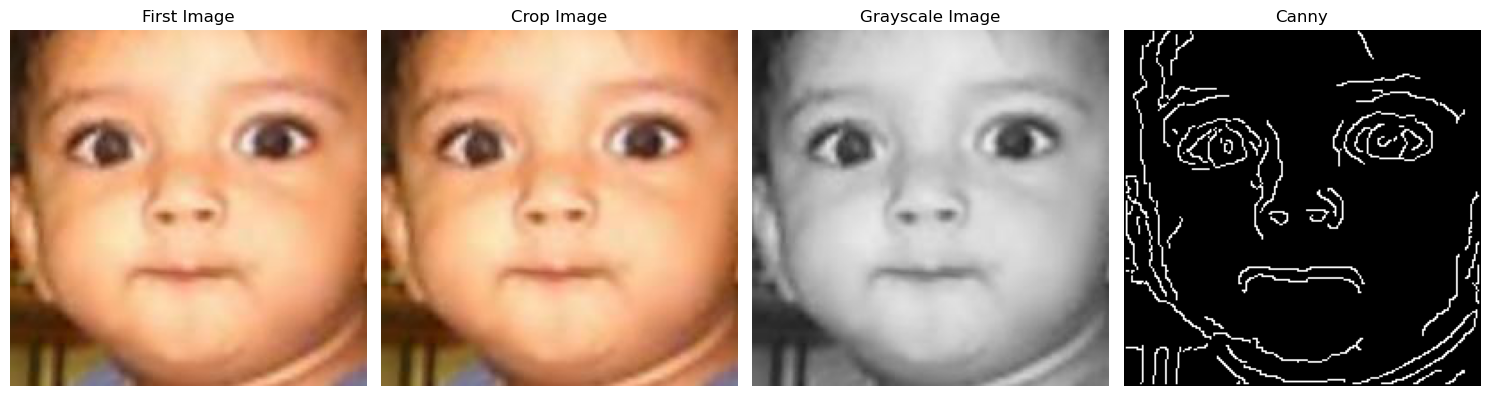

Jumlah Fitur Muka: 192
Fitur Muka:
[9.2799999e-02 2.9015195e-01 5.8000000e+01 6.5600000e-02 2.4758159e-01
 4.1000000e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 3.6800001e-02 1.8827045e-01 2.3000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.0560000e-01
 3.0732498e-01 6.6000000e+01 1.0720000e-01 3.0936736e-01 6.7000000e+01
 1.9200001e-02 1.3722740e-01 1.2000000e+01 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.1200000e-02 1.0523573e-01 7.0000000e+00 1.1680000e-01
 3.2118180e-01 7.3000000e+01 9.7599998e-02 2.9677305e-01 6.1000000e+01
 4.1600000e-02 1.9967334e-01 2.6000000e+01 7.0400000e-02 2.5581995e-01
 4.4000000e+01 1.6800000e-01 3.7386629e-01 1.0500000e+02 1.7440000e-01
 3.7945309e-01 1.0900000e+02 8.6400002e-02 2.8095379e-01 5.4000000e+01
 6.8800002e-02 2.5311372e-01 4.3000000e+01 1.8080001e-01 3.8485238e-01
 1.1300000e+02 1.6640000e-01 3.7243932e-01

In [30]:
image_path = 'dataset/final_dataset/test/001_613_0.png'

feature = extract_features_from_image(image_path)
print("Jumlah Fitur Muka:", len(feature))
print("Fitur Muka:")
print(feature)

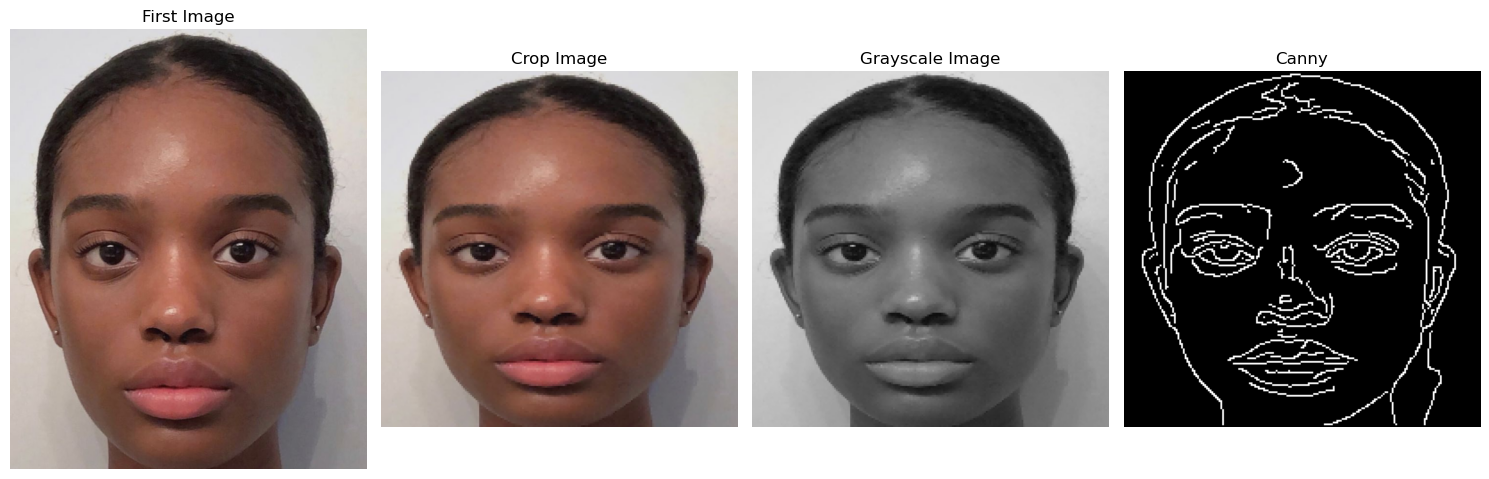

Jumlah Fitur Muka: 192
Fitur Muka:
[0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0400001e-02 1.7168529e-01
 1.9000000e+01 5.2800000e-02 2.2363399e-01 3.3000000e+01 1.7760000e-01
 3.8217565e-01 1.1100000e+02 1.0880000e-01 3.1138811e-01 6.8000000e+01
 5.6000002e-02 2.2992173e-01 3.5000000e+01 2.7200000e-02 1.6266580e-01
 1.7000000e+01 0.0000000e+00 0.0000000e+00 0.0000000e+00 3.0400001e-02
 1.7168529e-01 1.9000000e+01 1.0560000e-01 3.0732498e-01 6.6000000e+01
 9.1200002e-02 2.8789333e-01 5.7000000e+01 2.0800000e-02 1.4271426e-01
 1.3000000e+01 2.2399999e-02 1.4798054e-01 1.4000000e+01 5.9200000e-02
 2.3599865e-01 3.7000000e+01 9.2799999e-02 2.9015195e-01 5.8000000e+01
 1.2800000e-02 1.1241067e-01 8.0000000e+00 6.2399998e-02 2.4188063e-01
 3.9000000e+01 6.0800001e-02 2.3896310e-01 3.8000000e+01 0.0000000e+00
 0.0000000e+00 0.0000000e+00 5.2800000e-02 2.2363399e-01 3.3000000e+01
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 1.0560000e-01 3.0732498e-01

In [31]:
image_path = 'cekombak.jpg'

feature = extract_features_from_image(image_path)
print("Jumlah Fitur Muka:", len(feature))
print("Fitur Muka:")
print(feature)